<a href="https://colab.research.google.com/github/Seren-Smith/MLH-March-Challenges/blob/main/stock_market_GME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Doing a spin on MLH: March Challenge 3 surrounding the tumutulous "GME", as of March 23rd, 2021.

In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [4]:
# Get some data!!
df = web.DataReader('GME', data_source = 'yahoo', start = '2013-01-01', end = '2021-03-23')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2013-01-02,25.870001,24.990000,25.580000,25.660000,4898100.0,17.929613
2013-01-03,25.690001,23.920000,25.580000,24.360001,10642800.0,17.021255
2013-01-04,25.170000,24.360001,24.420000,24.799999,4040000.0,17.328697
2013-01-07,24.920000,23.870001,24.660000,24.750000,3983900.0,17.293760
2013-01-08,23.959999,22.660000,22.930000,23.190001,11131200.0,16.203733
...,...,...,...,...,...,...
2021-03-17,231.470001,204.000000,217.839996,209.809998,16259300.0,209.809998
2021-03-18,218.880005,195.649994,214.000000,201.750000,11764900.0,201.750000
2021-03-19,227.000000,182.660004,195.729996,200.270004,24552100.0,200.270004


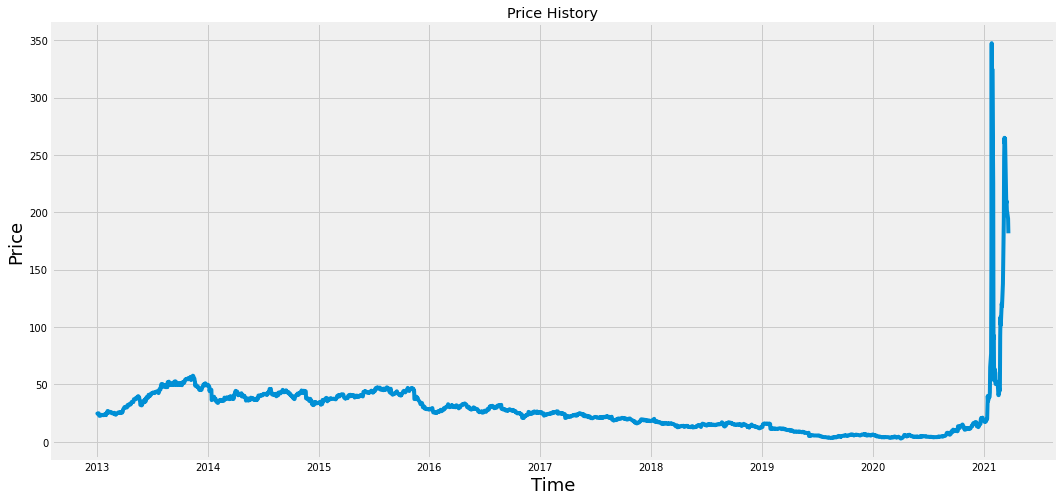

In [5]:
plt.figure(figsize=(16, 8))
plt.title("Price History")
plt.xlabel("Time", fontsize = 18)
plt.ylabel("Price", fontsize = 18)
plt.plot(df['Close'])
plt.show()

In [6]:
# Filter to just the close column
data = df.filter(['Close'])
# Convert data to numpy array
dataset = data.values
training_len = math.ceil(len(dataset) * 0.8)

# Scale the data
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.06631661],
       [0.06254533],
       [0.06382176],
       ...,
       [0.57285834],
       [0.55609063],
       [0.51913201]])

In [7]:
# Create Training Data
train_data = scaled_data[0:training_len, :]

x_train = []
y_train = []

for i in range(60, training_len):
  x_train.append(train_data[i - 60:i, 0]) # Get the data in the past 60 days for each iteration
  y_train.append(train_data[i, 0]) # Get the data of that day

  if i <= 60:
    print(x_train)
    print(y_train)
    print()

[array([0.06631661, 0.06254533, 0.06382176, 0.06367671, 0.05915117,
       0.0574686 , 0.05799078, 0.05932523, 0.05862899, 0.05906414,
       0.05880305, 0.06002147, 0.05941226, 0.0595283 , 0.05903513,
       0.05996344, 0.06065968, 0.06086275, 0.06155899, 0.06045661,
       0.05918018, 0.06350265, 0.06512721, 0.06965275, 0.06498216,
       0.06559136, 0.06747701, 0.06788315, 0.0668678 , 0.06738998,
       0.0665777 , 0.06547533, 0.06585245, 0.06535929, 0.06361869,
       0.06387978, 0.06327058, 0.06379275, 0.0650982 , 0.06457602,
       0.06164602, 0.06016652, 0.06237126, 0.06269038, 0.06306751,
       0.06344463, 0.06515622, 0.06579443, 0.0662876 , 0.06559136,
       0.06570741, 0.06649067, 0.0650982 , 0.06570741, 0.0650982 ,
       0.06631661, 0.06550433, 0.06834731, 0.0686084 , 0.0730179 ])]
[0.0782106684142036]



In [8]:
# Convert NumPy
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape our Data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build our LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))

# Densely Connected NN
model.add(Dense(30))
model.add(Dense(1))

In [9]:
# Compile our Model
model.compile(optimizer = "rmsprop", loss = "mean_squared_error")

model.fit(x_train, y_train, batch_size = 1)

1596/1596 [==============================] - 37s 21ms/step - loss: 2.8283e-04


In [10]:
test_data = scaled_data[training_len - 60:, :]

x_test = []
y_test = dataset[training_len:, :]

for i in range(60, len(test_data)):
  x_test.append(test_data[i - 60:i, :])

# Reshape and convert to NumPy
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get Predictions
pred = model.predict(x_test)
pred = scaler.inverse_transform(pred)

In [11]:
# See total error in predictions
rmse = np.sqrt(np.mean((pred - y_test) ** 2))
rmse

26.974699640638896

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


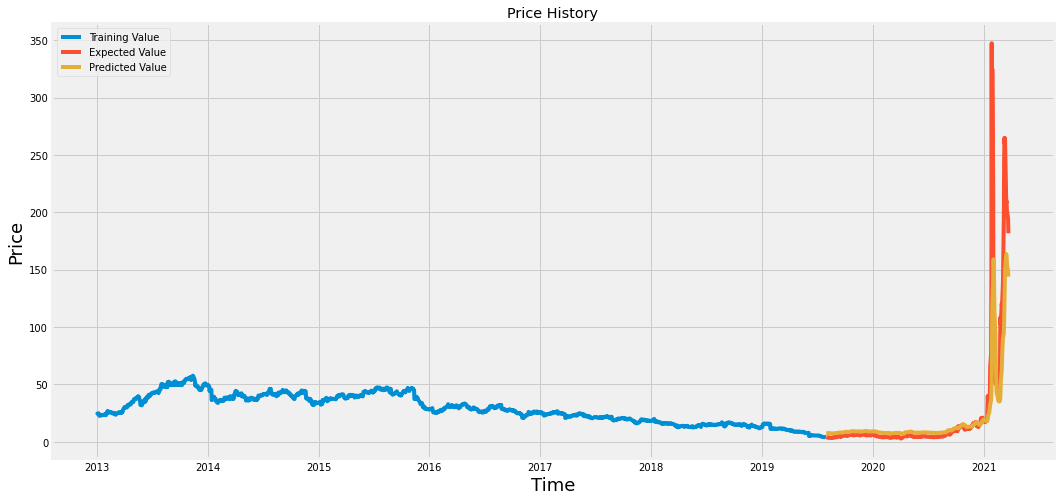

In [12]:
# Set up some plot data
train = data[:training_len]
expected = data[training_len:]
expected['Predictions'] = pred

# Visualize outputs
plt.figure(figsize=(16,8))
plt.title("Price History")
plt.xlabel("Time", fontsize = 18)
plt.ylabel("Price", fontsize = 18)
plt.plot(train['Close'])
plt.plot(expected[['Close', 'Predictions']])
plt.legend(["Training Value", "Expected Value", "Predicted Value"])
plt.show()

In [13]:
expected

,Close,Predictions
Date,,
2019-08-01,3.840000,7.653894
2019-08-02,3.780000,7.631361
2019-08-05,3.710000,7.596527
2019-08-06,3.810000,7.552644
2019-08-07,3.810000,7.521419
...,...,...
2021-03-17,209.809998,161.753906
2021-03-18,201.750000,158.080093
2021-03-19,200.270004,153.278534


In [14]:
quote = web.DataReader('AAPL', data_source = 'yahoo', start = '2013-01-01', end = '2021-03-03')
new_df = quote.filter(['Close'])

# Last 60 days of data
last_60 = new_df[-60:]

# Scale Data
last_60_scaled = scaler.fit_transform(last_60)

# Test data
x_last_60 = []
x_last_60.append(last_60_scaled)

# Convert and reshape
x_last_60 = np.array(x_last_60)
x_last_60 = np.reshape(x_last_60, (x_last_60.shape[0], x_last_60.shape[1], 1))

prediction_price = model.predict(x_last_60)
prediction_price = scaler.inverse_transform(prediction_price)

prediction_price

array([[123.30262]], dtype=float32)